In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True)
    
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,)) # global meaen and Sd for the MNIST dataset
                                ])),
    batch_size=batch_size_train, shuffle=True)

In [4]:
# let's look at an example
ex = enumerate(test_loader)

batch_idx, (example_data, example_targets) = next(ex)

In [5]:
example_data[0].mean()

tensor(0.0085)

In [6]:
example_data.shape

torch.Size([64, 1, 28, 28])

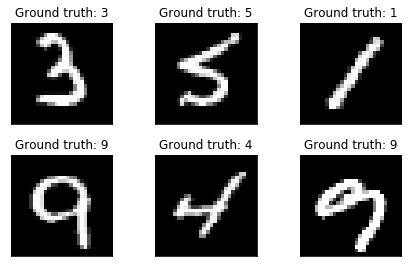

In [7]:
# let's plot some

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    
#fig

In [8]:
# Build the model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i+len(train_loader.dataset) for i in range(n_epochs+1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct /len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Billi\Anaconda3\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3078, Accuracy: 722/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319053
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.315167
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293813
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272953
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.256619
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.269554
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.276610
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.241360
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.224388
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.212374
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.171557
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.120941
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.983747
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.005888
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.810310
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.791353
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.657935
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.688185
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.402852
Train Epoch: 1 [12160/6

## Let's Check the plots

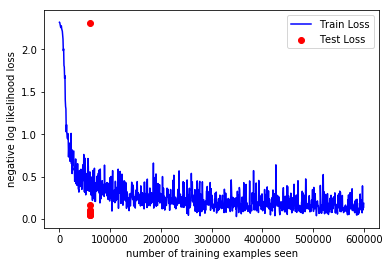

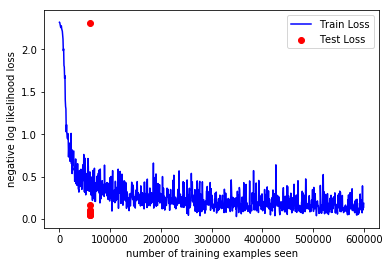

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [15]:
# looking at the figure, it seems that we can continue training.
# let's take a look at example data:

with torch.no_grad():
    output = network(example_data)

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


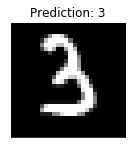

In [16]:
fig = plt.figure()
for i in range(1):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
    

### Continuing training from previous checkpoints

In [18]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [19]:
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [20]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.107147
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.057184
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.107738
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.255714
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.096512
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.169195
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.097293
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.139079
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.094682
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.616552
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.201540
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.094005
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.366445
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.142173
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.372437
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.198423
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.174247
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.130782
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.298647
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.245207
Train Epoch: 4 [12800/60000 (

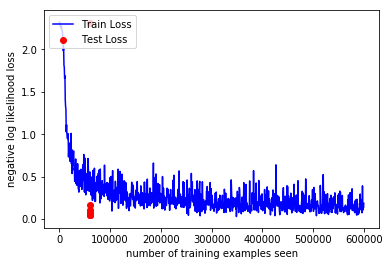

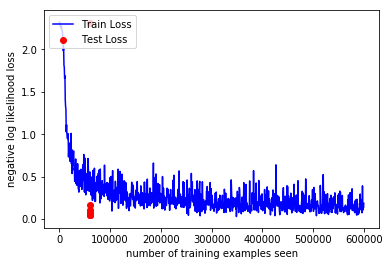

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc ='upper left')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig


In [124]:
# loading image for recognition


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import cv2
import os
from torchvision import transforms
import torch
import pickle
from random import shuffle

In [10]:
import operator
import cv2
import numpy as np
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""
    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)
    #if not skip_dilate:
    #    # Dilate the image to increase the size of the grid lines.
    #    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
    #    proc = cv2.dilate(proc, kernel)
    return proc
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()
    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = find_corners_of_largest_polygon(img)
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_image(img)
    return img
def show_image(img):
    """Shows an image until any key is pressed."""
    cv2.imshow('image', img)  # Display the image
    cv2.waitKey(0)  # Wait for any key to be pressed (with the image window active)
    cv2.destroyAllWindows()  # Close all windows
def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""
	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])
	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)
	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


In [38]:
img = cv2.imread('./images/img10.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(img, corners)
show_image(cropped)

In [39]:
cv2.imwrite( "./images/img10.jpg", cropped)


True

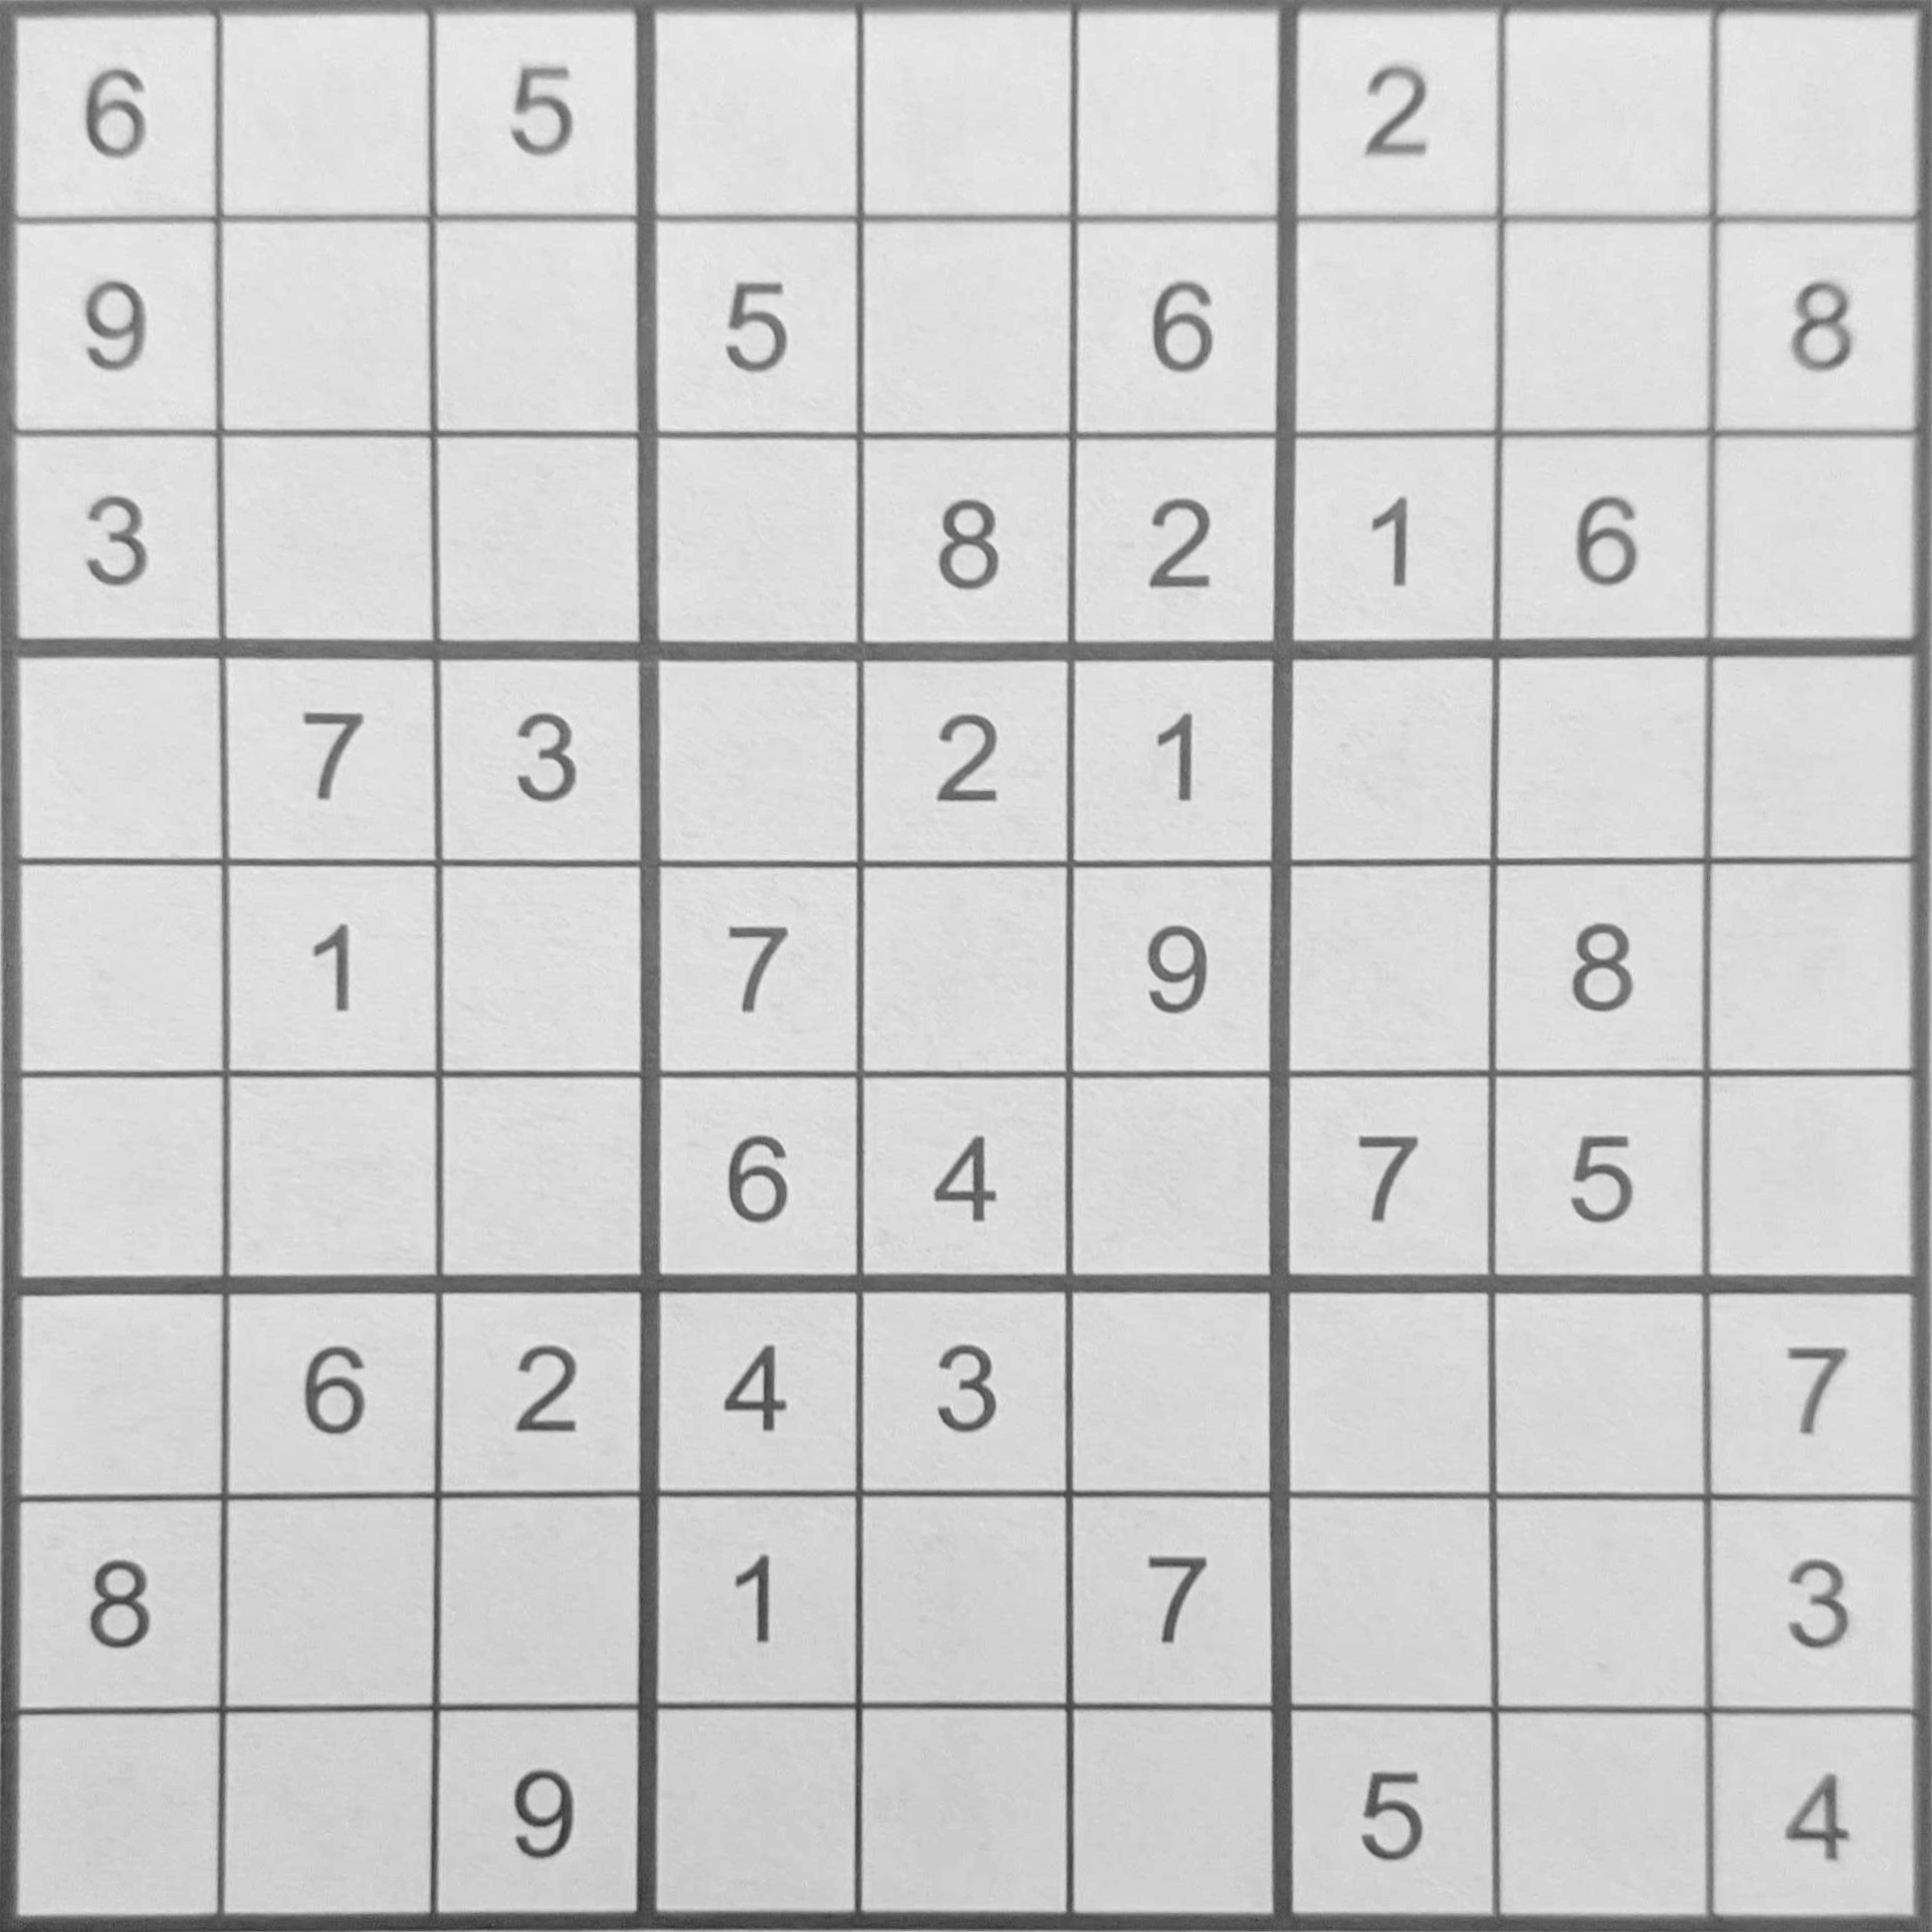

In [40]:
(Image(filename='./images/img10.jpg'))

In [41]:
filename = './images/img10.jpg'
img = cv2.imread(filename)

In [42]:
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

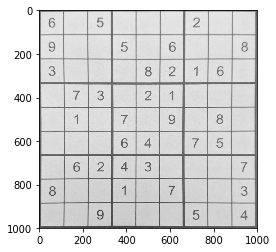

In [43]:
W = 1000
heigh, width, depth = img.shape
imgScale = W/width
newX, newY = img.shape[1]*imgScale, img.shape[0]*imgScale
new_img = cv2.resize(img, (int(newX), int(newY)))
cv2.imshow("Show by CV2", new_img)
cv2.waitKey(0)
cv2.imwrite('resize_white_img.png', new_img)
plt.imshow(new_img) 

In [44]:
invert_img = cv2.bitwise_not(new_img)
cv2.imshow("invert1", invert_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [45]:
threshold, invert_img = cv2.threshold(invert_img, 60, 255, cv2.THRESH_BINARY)

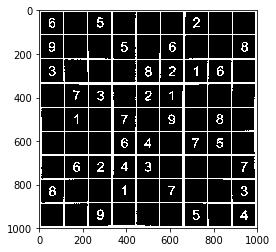

In [46]:
plt.imshow(invert_img)

#### invert_img = (cv2.threshold(invert_img, 100, 255, cv2.THRESH_BINARY))
invert_img = cv2.threshold(invert_img, 10, b qgf10, cv2.THRESH_BINARY)

In [34]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
sharpened = cv2.filter2D(invert_img[1], -1, kernel_sharpening)
cv2.imshow('Image Sharpening', sharpened)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [35]:
rows = [(30,110), (125,205), (235,315), (350,430), (455,535), (580,660), (680,760), (785,865), (890,970)]
columns = [(30,110), (130,210), (240,320), (355,435), (455,535), (575,655), (680,760), (800,880),(890,970)]
images_list = []
for unit in rows:
    for units in columns:
        images_list.append(invert_img[unit[0]:unit[1], units[0]:units[1]])

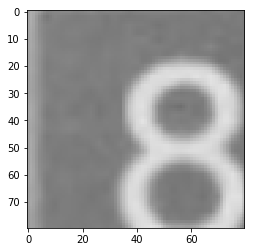

In [36]:
plt.imshow(images_list[71])

In [347]:
final_images = []
for i in range(len(images_list)):
#    img_array = cv2.imread(os.path.join(IMG_DIR, images))
    img_array = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_array, (28,28))
    #new_img = cv2.threshold(resize_img, 115, 255, cv2.THRESH_BINARY)
    final_images.append(resize_img)

In [348]:
# transform = transforms.ToTensor()
# torchvision.transforms.Normalize(0.1307,), (0.3081,)
tensor_images = []
for images in final_images:
    tensors = torch.tensor(images, dtype=torch.float)
    tensor_images.append(tensors)

In [349]:
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [350]:
continued_network.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [351]:
final_images[2].mean(), final_images[78].mean()

(14.4375, 31.617346938775512)

In [352]:
for i in range(len(tensor_images)):
    print(tensor_images[i].mean())

tensor(0.)
tensor(0.)
tensor(14.4375)
tensor(25.3457)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(32.1148)
tensor(0.)
tensor(29.1480)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(30.8546)
tensor(18.4821)
tensor(0.)
tensor(26.5242)
tensor(27.7423)
tensor(25.2589)
tensor(0.)
tensor(0.)
tensor(26.7181)
tensor(0.)
tensor(0.)
tensor(31.2755)
tensor(26.7755)
tensor(0.)
tensor(0.)
tensor(24.4222)
tensor(0.)
tensor(0.)
tensor(29.9783)
tensor(0.)
tensor(19.0778)
tensor(0.)
tensor(26.8520)
tensor(0.)
tensor(0.)
tensor(29.2564)
tensor(23.6709)
tensor(0.)
tensor(15.0395)
tensor(24.3316)
tensor(0.)
tensor(0.)
tensor(14.4681)
tensor(0.)
tensor(25.9528)
tensor(0.)
tensor(24.9898)
tensor(0.)
tensor(0.)
tensor(30.0612)
tensor(0.)
tensor(0.)
tensor(15.4732)
tensor(30.6276)
tensor(0.)
tensor(0.)
tensor(23.8941)
tensor(0.)
tensor(0.)
tensor(31.9247)
tensor(28.3431)
tensor(28.5676)
tensor(0.)
tensor(14.6339)
tensor(19.2857)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(27.4605)
tensor(0.)
tensor(19.2551)
tensor(0.)
tenso

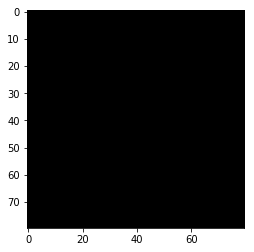

In [353]:
plt.imshow(images_list[6])

In [354]:
images_list[6].mean()

0.0

In [355]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor)):
        if tensor[i].mean().item() <= 10:
            grid.append(".")
        else:
            grid.append(str(continued_network(tensor[i].view(1,1,28,28)).argmax().item()))
    return grid

In [356]:
str(continued_network(tensor_images[9].view(1,1,28,28)).argmax().item())

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'9'

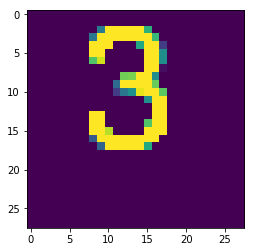

In [357]:
plt.imshow(final_images[3])

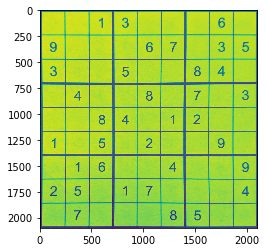

In [358]:
plt.imshow(cropped)

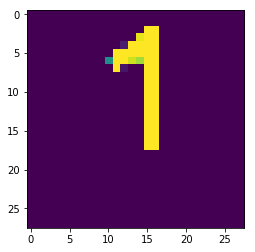

In [364]:
plt.imshow(final_images[2])

In [362]:
convert(tensor_images)

C:\Users\Billi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


['.',
 '.',
 '3',
 '9',
 '.',
 '.',
 '.',
 '9',
 '.',
 '9',
 '.',
 '.',
 '.',
 '5',
 '7',
 '.',
 '3',
 '5',
 '3',
 '.',
 '.',
 '5',
 '.',
 '.',
 '8',
 '6',
 '.',
 '.',
 '4',
 '.',
 '.',
 '8',
 '.',
 '7',
 '.',
 '2',
 '.',
 '.',
 '8',
 '6',
 '.',
 '1',
 '2',
 '.',
 '.',
 '1',
 '.',
 '2',
 '.',
 '2',
 '.',
 '.',
 '9',
 '.',
 '.',
 '7',
 '6',
 '.',
 '.',
 '4',
 '.',
 '.',
 '1',
 '2',
 '5',
 '.',
 '1',
 '7',
 '.',
 '.',
 '.',
 '2',
 '.',
 '7',
 '.',
 '.',
 '.',
 '8',
 '5',
 '.',
 '.']

In [360]:
plt.imshow(

SyntaxError: unexpected EOF while parsing (<ipython-input-360-9c6170dfe46f>, line 1)

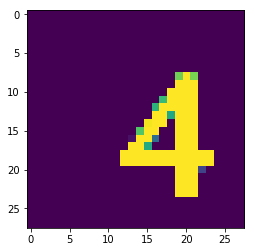

In [302]:
plt.imshow(final_images[71])

In [221]:
final_images[74].mean()

27.321428571428573